## Reading the .csv containing the file names and the steering angles

### Loading the file names  and steering angles into samples
### Splitting samples into train and validation samples

In [1]:
def  extractFileName ( abs_path):

    import os
    if os.name == "nt":
        split_char = '\\' 
    else:
        split_char = '/' 
    if '\\' in abs_path:
        # "  Windows Path " 
        image_name = abs_path.split ('\\')[-3] \
                            + split_char + abs_path.split ('\\')[-2] \
                            + split_char + abs_path.split ('\\')[-1]

    else:
        # "  Unix Path " 
        image_name = abs_path.split ('/')[-3] \
                            + split_char + abs_path.split ('/')[-2] \
                            + split_char + abs_path.split ('/')[-1]
    
    return image_name

#### Defining the resize shape of the images ( this parameter will be used also in the Generator and in the Model definition)

In [2]:
resized_shape = 128

### Defining the PyTable

In [3]:
from  tables import *
import tables


In [4]:
hdf5_file.close()

NameError: name 'hdf5_file' is not defined

In [6]:
hdf5_file = open_file("./data/samples.hdf5", mode = "w", title = "Samples")


ValueError: The file './data/samples.hdf5' is already opened.  Please close it before reopening in write mode.

### Defining the two objects as images container:


In [7]:
py_training_samples = hdf5_file.create_earray(hdf5_file.root, \
                    'train_img', \
                    tables.UInt8Atom(), \
                    shape=( 0,resized_shape, resized_shape, 3))

py_validation_samples      = hdf5_file.create_earray(hdf5_file.root, \
                     'val_img', tables.UInt8Atom(), \
                     shape=( 0,resized_shape, resized_shape, 3))



In [8]:
import os
import csv
import cv2
import numpy as np
import glob

print ( "Starting .... ")
samples_list = []
center_image_before = None
for name in glob.glob("./data/*.csv"):
    print ( "Reading from logfile = " + name)
    with open(name)  as csvfile:
            reader = csv.reader(csvfile)
            for line in reader:
                # STEERING ANGLE CALCULATION
                samples_list.append([extractFileName( line[0]),\
                                     extractFileName( line[1]),\
                                     extractFileName( line[2]),\
                                     float(line[3])])
                
samples_list = np.array(samples_list)

from random import shuffle
shuffle(samples_list)

train_list = samples_list[0:int(0.8*len(samples_list))]

val_list = samples_list[int(0.8*len(samples_list)):int(1.0*len(samples_list))]


print ("\n\nThere are {} images in total ".format(len(samples_list)))
print ("....splitted into training images = {}  ".format(len(train_list)))
print ("                  val images      = {}  ".format(len(val_list)))


Starting .... 
Reading from logfile = ./data/track2_run1.csv
Reading from logfile = ./data/run5.csv
Reading from logfile = ./data/run6.csv
Reading from logfile = ./data/track2_run4.csv
Reading from logfile = ./data/track2_run2.csv
Reading from logfile = ./data/run2.csv
Reading from logfile = ./data/run1.csv
Reading from logfile = ./data/track2_run3.csv
Reading from logfile = ./data/run4.csv
Reading from logfile = ./data/runx.csv
Reading from logfile = ./data/run3.csv
Reading from logfile = ./data/run7.csv
Reading from logfile = ./data/run9.csv


There are 18713 images in total 
....splitted into training images = 14970  
                  val images      = 3743  


In [9]:
# train_list = train_list[0:100 ]
# train_list.shape

In [10]:
def data_preprocess(line):
        preprocessed_samples=[]
        # STEERING ANGLE CALCULATION
        correction = 0.03 # this is a parameter to tune
        center_steering = float(line[3])
        left_steering   = center_steering + correction
        right_steering  = center_steering - correction

        # CENTER IMAGE
        center_image = cv2.imread(extractFileName( line[0]))
        center_image = cv2.cvtColor (center_image, cv2.COLOR_BGR2RGB)
        center_image = cv2.resize(center_image,(resized_shape,resized_shape ))
        preprocessed_samples.append([center_image, center_steering ])

        #   LEFT IMAGE
        left_image = cv2.imread(extractFileName( line[1]))
        left_image = cv2.cvtColor (left_image, cv2.COLOR_BGR2RGB)
        left_image = cv2.resize(left_image,(resized_shape,resized_shape ))
        preprocessed_samples.append([left_image, left_steering ])

        #   RIGHT IMAGE
        right_image = cv2.imread(extractFileName( line[2]))
        right_image = cv2.cvtColor (right_image, cv2.COLOR_BGR2RGB)
        right_image = cv2.resize(right_image,(resized_shape,resized_shape ))
        preprocessed_samples.append([right_image, right_steering ])


        ###
        ### IMAGE AUGMENTATION
        ###
        # augmented center image
        preprocessed_samples.append([cv2.flip(center_image,1), center_steering*-1.0 ])

        # augmented left image
        preprocessed_samples.append([cv2.flip(left_image  ,1), left_steering  *-1.0] )

        # augmented right image
        preprocessed_samples.append([cv2.flip(right_image,1),  right_steering *-1.0] )
        
#         print ( "here 1 {}".format( np.array(preprocessed_samples).shape))
        return np.array(preprocessed_samples)

### Image preprocessing using the function defined before

In [12]:
    
import os
import csv
import cv2
import numpy as np
import glob

print ( "Starting Preprocessing the images  .... ")
train_samples      =  np.array([]).reshape(0,2)
validation_samples =  np.array([]).reshape(0,2)
training_steering = []
val_steering = []

for i,sample_line in enumerate(train_list):
   for output in data_preprocess(sample_line):
#         print (output[0].shape)
        py_training_samples.append(output[0][None])
        training_steering.append(output[1])
          
   if i% 1000 == 0 and i> 0 : print(".. training samples processed {}".format(i))     
   
for i,sample_line in enumerate(val_list):
   for output in data_preprocess(sample_line):
#         print ( "output[0].shape" + str(output[0].shape))
        py_validation_samples.append(output[0][None])
        val_steering.append(output[1])
#         print (output[0][None].shape)

   if i% 1000 == 0 and i> 0 : print(".. validation samples processed {}".format(i))     


print ("\nTotal training samples {}x{} after augmentation and preprocessing : {} "\
       .format(resized_shape,resized_shape,\
        str(len(py_training_samples)) ))
print ("\nTotal validation samples {}x{} after augmentation and preprocessing : {} "\
       .format(resized_shape,resized_shape,\
        str(len(py_validation_samples)) ))
print ( "... completed")


Starting Preprocessing the images  .... 
.. training samples processed 1000
.. training samples processed 2000
.. training samples processed 3000
.. training samples processed 4000
.. training samples processed 5000
.. training samples processed 6000
.. training samples processed 7000
.. training samples processed 8000
.. training samples processed 9000
.. training samples processed 10000
.. training samples processed 11000
.. training samples processed 12000
.. training samples processed 13000
.. training samples processed 14000
.. validation samples processed 1000
.. validation samples processed 2000
.. validation samples processed 3000

Total training samples 128x128 after augmentation and preprocessing : 89820 

Total validation samples 128x128 after augmentation and preprocessing : 22458 
... completed


### Defining the table arrays and copying the labels data inside


In [11]:
py_training_steerings = hdf5_file.create_array(hdf5_file.root, 'py_training_steering',training_steering )
py_val_steerings = hdf5_file.create_array(hdf5_file.root, 'py_val_steering', val_steering)

NameError: name 'training_steering' is not defined

## EXPLORING THE DATA


Exploring the dataset ...


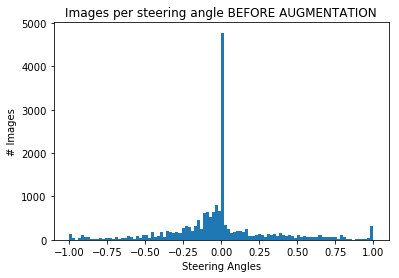

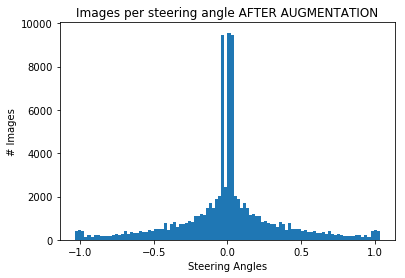

Exploring the dataset complete.


In [36]:
import matplotlib.pyplot as plt
 
print("\nExploring the dataset ...")
 
# It plots the histogram of an arrray of angles: [0.0,0.1, ..., -0.1]
def plot_steering_histogram(steerings, title, num_bins=100):
    plt.hist(steerings, num_bins)
    plt.title(title)
    plt.xlabel('Steering Angles')
    plt.ylabel('# Images')
    plt.show()
 
# # It plots the histogram of an arrray of associative arrays of angles: [{'steering':0.1}, {'steering':0.2}, ..., {'steering':-0.1}]
def plot_dataset_histogram(samples, title, num_bins=100):
    steerings = []
    for item in samples:
#         print (item)
        steerings.append( float(item) )
    plot_steering_histogram(steerings, title, num_bins)

samples_before = samples_list[:,3]
# Plot the histogram of steering angles before the image augmentation
plot_dataset_histogram(samples_before, 'Images per steering angle BEFORE AUGMENTATION', num_bins=100)
samples_before = []

# Plot the histogram of steering angles after the image augmentation
plot_dataset_histogram(training_steering, 'Images per steering angle AFTER AUGMENTATION', num_bins=100)
print("Exploring the dataset complete.")
samples=[]




## Model definition using Keras

#### NVIDIA model used
#### Image normalization to avoid saturation and make gradients work better.
####     Convolution: 5x5, filter: 24, strides: 2x2, activation: ELU
####     Convolution: 5x5, filter: 36, strides: 2x2, activation: ELU
####     Convolution: 5x5, filter: 48, strides: 2x2, activation: ELU
####     Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
####     Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
####     Drop out (0.5)
####     Fully connected: neurons: 100, activation: ELU
####     Fully connected: neurons: 50, activation: ELU
####     Fully connected: neurons: 10, activation: ELU
####     Fully connected: neurons: 1 (output)

In [37]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Activation, Dropout, Reshape
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
top_crop = int(resized_shape*10/100)
bottom_crop = int(resized_shape*34/100)

# Data Preprocessing ( Normalization and mean centering)
model.add(Cropping2D(cropping =((bottom_crop,top_crop),(0,0)), input_shape = (resized_shape,resized_shape,3), name ="cropping") )
model.add(Lambda(lambda x: x/127.5 - 1. , input_shape = (resized_shape,resized_shape,3)))

model.add(Conv2D(24, (5, 5), activation='elu', padding='valid',strides=(2, 2), name = "Conv1"))

model.add(Conv2D(36, (5, 5), activation='elu', padding='valid',strides=(2, 2), name = "Conv2"))

model.add(Conv2D(48, (5, 5), activation='elu', padding='valid',strides=(2, 2), name = "Conv3"))

model.add(Conv2D(64, (3, 3), activation='elu', padding='valid',strides=(1, 1), name = "Conv4"))
model.add(Conv2D(64, (3, 3), activation='elu', padding='valid',strides=(1, 1), name = "Conv5"))

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(100, activation='elu',kernel_initializer='random_uniform',bias_initializer='zeros'))
model.add(Dense(50, activation='elu',kernel_initializer='random_uniform',bias_initializer='zeros'))
model.add(Dense(10, activation='elu',kernel_initializer='random_uniform',bias_initializer='zeros'))
model.add(Dense(1,kernel_initializer='random_uniform',bias_initializer='zeros'))

model.compile(loss='mse', optimizer='adam')

print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping (Cropping2D)        (None, 73, 128, 3)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 73, 128, 3)        0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 35, 62, 24)        1824      
_________________________________________________________________
Conv2 (Conv2D)               (None, 16, 29, 36)        21636     
_________________________________________________________________
Conv3 (Conv2D)               (None, 6, 13, 48)         43248     
_________________________________________________________________
Conv4 (Conv2D)               (None, 4, 11, 64)         27712     
_________________________________________________________________
Conv5 (Conv2D)               (None, 2, 9, 64)          36928     
__________

## Defining the generator .
### This flushes the files content from disk and return it to Tensorflow for the training fit
### The generator is repeated many times ( as many Epochs of training )



### Defining the Queue Thread process
#### Here I am creating a function that will be called in a separate thread . This simply read big Chunks from Disk ( also the Pytable ) , shuffle them, and make them at disposition of a further processer in a Python Queue.
#### The size of this two Queue , samples_q and labels_q is defined as batch_size * 100, so for example 3200 samples
#### The great thing about Python Queue is that , if we define the maxsize, the put instruction in case the Queue is full, will wait until will be some space free. 
#### **** This is useful to AVOID TO LOAD THE ENTIRE PYTABLE IN MEMORY ****

In [38]:
## Defining the batch size:
batch_size = 32

In [39]:
import sklearn

def read_images_into_queue(samples_q, labels_q , samples, labels):
    print ( " reading images into Queue")
    # Define the Queue max size , the Queue.put() automatically do wait until records will be get from 
    # an other process and will free some space in the queue.
#     From docs.python.org:
#     The Queue module implements multi-producer, multi-consumer queues. 
#     It is especially useful in threaded programming when information must be exchanged safely between multiple threads. 
#     The Queue class in this module implements all the required locking semantics. 
#     It depends on the availability of thread support in Python; see the threading module.
    
    numsamples = len(samples)
    while 1:  ### remember you need to stop the process !!
        print ("numsamples = " + str(numsamples))
        for offset in range(0, numsamples, batch_size*100):
             print ( "offset = " + str(offset))
             # loading into memory a BIG chunk of data ( 3200 samples )
             chunk_batch_samples = samples[offset:offset+batch_size*100]
             chunk_batch_labels  = labels[offset:offset+batch_size*100]
             print ("chunk_batch_samples size {}".format(chunk_batch_samples.shape) )
             # shuffle the chunk
             chunk_batch_samples,chunk_batch_labels = sklearn.utils.shuffle(chunk_batch_samples,chunk_batch_labels)  
             for sample, steering in zip ( chunk_batch_samples,chunk_batch_labels):
                samples_q.put(sample)
                labels_q.put(steering)
    

In [47]:
import cv2
import numpy as np
import sklearn


def generator(samples_q, labels_q, batch_size ):
    read_nb = 0
    while 1: # Loop forever so the generator never terminates
        
        images = []
        angles=[]
        for i in range(0, batch_size):
            images.append(samples_q.get())
            angles.append(labels_q.get())

        yield np.array(images) , np.array(angles)


#### Starting the reading process -- from Disk to Memory Queue
#### Remember to TERMINATE it !!

In [48]:
from multiprocessing import Process, Queue

training_samples_q = Queue(maxsize = batch_size * 100)
training_labels_q = Queue(maxsize = batch_size * 100)

validation_samples_q = Queue(maxsize = batch_size * 100)
validatio_labels_q = Queue(maxsize = batch_size * 100)

###############################################################
# Training Producer. It loads training data into Queues
###############################################################
training_producer = Process(target=read_images_into_queue, 
                            args=(training_samples_q,            # <-- Training images queue
                                  training_labels_q,             # <-- Training labels queue
                                  py_training_samples,           # <-- Training samples Pytable
                                  py_training_steerings))        # <-- Training labels  Pytable
training_producer.start()

###############################################################
# Validation Producer. It loads validation data into Queues
###############################################################
validation_producer = Process(target=read_images_into_queue, 
                            args=(validation_samples,              # <-- Training images queue
                                  validation_labels,               # <-- Training labels queue
                                  py_validation_samples,           # <-- Training samples Pytable
                                  py_validation_steerings))        # <-- Training labels  Pytable
validation_producer.start()


## training_producer.terminate()
## validation_producer.terminate()



 reading images into Queue
numsamples = 89820
offset = 0
chunk_batch_samples size (3200, 128, 128, 3)
offset = 3200
chunk_batch_samples size (3200, 128, 128, 3)
offset = 6400
chunk_batch_samples size (3200, 128, 128, 3)
offset = 9600
chunk_batch_samples size (3200, 128, 128, 3)
offset = 12800
chunk_batch_samples size (3200, 128, 128, 3)
offset = 16000
chunk_batch_samples size (3200, 128, 128, 3)
offset = 19200
chunk_batch_samples size (3200, 128, 128, 3)
offset = 22400
chunk_batch_samples size (3200, 128, 128, 3)
offset = 25600
chunk_batch_samples size (3200, 128, 128, 3)
offset = 28800
chunk_batch_samples size (3200, 128, 128, 3)
offset = 32000
chunk_batch_samples size (3200, 128, 128, 3)
offset = 35200
chunk_batch_samples size (3200, 128, 128, 3)
offset = 38400
chunk_batch_samples size (3200, 128, 128, 3)
offset = 41600
chunk_batch_samples size (3200, 128, 128, 3)
offset = 44800
chunk_batch_samples size (3200, 128, 128, 3)
offset = 48000
chunk_batch_samples size (3200, 128, 128, 3)
o

In [49]:
# producer.terminate()

#### Defining the epochs

In [50]:
epochs = 1

#### Creating the Train and Validation generators:

In [51]:
## Note that the traing_generator uses Queue and async thread !
train_generator      = generator(training_samples_q, 
                                 training_labels_q, 
                                 batch_size)

validation_generator = generator(validation_samples_q, 
                                 validation_steerings_q, 
                                 batch_size)

#### Training the model using traing_generator and validating with validation_generator

In [52]:
from datetime import datetime
start_time = datetime.now()

model.compile(loss='mse', optimizer='adam')

numper_of_train_samples      = len(py_training_samples)
number_of_validation_samples = len(py_val_samples) 

history_object = model.fit_generator(train_generator, steps_per_epoch= \
                                     numper_of_train_samples/batch_size, 
                                     validation_data=validation_generator, \
                                     validation_steps=number_of_validation_samples/batch_size, 
                                     epochs=epochs, verbose = 1,\
                                     workers=1)

end_time = datetime.now()
print('\nTotal number of train samples: {} ( shape {}x{})'.format(numper_of_train_samples,resized_shape,resized_shape))
print('\nBatch Size                   : {}'.format(batch_size))
print('\nDuration                     : {}'.format(end_time - start_time))

from keras.models import save_model

save_model(model, "selfdrive_model.h5")
print ( "  ")
print ( " .. model saved to selfdrive_model.h5 ")
print ( "  ")


### print the keys contained in the history object
print(history_object.history.keys())

import matplotlib.pyplot as plt
# # # Visualizations will be shown in the notebook.
%matplotlib inline

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


Epoch 1/1
2806/2806 [============================>.] - ETA: 0s - loss: 0.0476

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/cristianku/anaconda3/envs/carnd-term1-gpu/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/cristianku/anaconda3/envs/carnd-term1-gpu/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/home/cristianku/anaconda3/envs/carnd-term1-gpu/lib/python3.5/site-packages/keras/utils/data_utils.py", line 568, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-47-930f76e5f7cc>", line 15, in generator
    images.append(samples_q.get())
AttributeError: 'EArray' object has no attribute 'get'



StopIteration: 

In [ ]:
producer.terminate()

#### Image Convolution broken down in small pieces 

### Here I am trying to visualize the Convolution Layers to understand visually how many filters I should use

In [ ]:
print (" Loading drive.h5 .......")

from keras.models import load_model
from keras.models import Model

modelobj = load_model('drive.h5')
print (" ..... model drive.h5 successfully loaded")


#### For this purpose I am loading a Test image from disk

In [ ]:
# Load test images
import cv2
import numpy as np
test_images = []

image = cv2.imread('./test_images/center1.jpg')
image = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image,(resized_shape,resized_shape ))     
test_images.append(image)


test_images = np.array(test_images)


#### First of all I am looking at the Image Crop if is well done in the right position:

In [ ]:
# Call the model to calculate an intermediate layer using the test images
layer_name = 'cropping'
intermediate_layer_model = Model(inputs=modelobj.input,
                                 outputs=modelobj.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(test_images)
intermediate_output.shape


In [ ]:
# Show the cropped images
def show_intermediate_output(image_ori, intermediate_output):
    print (intermediate_output.shape)
    depth = 0 
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20, 100))
    new_image = []
    plt.subplot(40, 5, 1 )
    plt.axis('off')
    plt.imshow(image_ori)
    for i in range(0,intermediate_output[0,0].shape[0]):
           single_output = intermediate_output[:,:,i]
#            print ( "single_output.shape {}".format(single_output.shape ))
#            print ( single_output)
           plt.subplot(40, 5, i+2 )
           plt.axis('off')
           single_output = single_output.astype(np.uint8)
           plt.imshow(single_output, cmap='gray')
    plt.show()    

    
show_intermediate_output(test_images[0], intermediate_output[0])

#### Now the FIRST convolutional layer:

In [ ]:
# Call the model to calculate an intermediate layer using the test images
layer_name = 'Conv1'
intermediate_layer_model = Model(input=model.input,
                                 output=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(test_images)
int_unNorm = (intermediate_output[0]+1) * 127.5
show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

#### Now the SECOND convolutional layer:

In [ ]:
# Call the model to calculate an intermediate layer using the test images
layer_name = 'Conv2'
intermediate_layer_model = Model(input=model.input,
                                 output=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(test_images)
int_unNorm = (intermediate_output[0]+1) * 127.5
show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

### Conv 3

In [ ]:
# Call the model to calculate an intermediate layer using the test images
layer_name = 'Conv3'
intermediate_layer_model = Model(input=model.input,
                                 output=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(test_images)
int_unNorm = (intermediate_output[0]+1) * 127.5
show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

### Conv 4

In [ ]:
# Call the model to calculate an intermediate layer using the test images
layer_name = 'Conv4'
intermediate_layer_model = Model(input=model.input,
                                 output=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(test_images)
int_unNorm = (intermediate_output[0]+1) * 127.5
show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

### Model Visualization

In [ ]:
import cv2
from keras.utils.visualize_util import plot
from keras.models import load_model
%matplotlib inline

#visualize the model
modelobj = load_model('model.h5')
plot (modelobj, to_file='model.png')
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 100))
image = cv2.imread('model.png')
image = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
plt.subplot(5, 5, 1)
plt.axis('off')

plt.imshow(image)
plt.show()
